ELECTRE Thresholds → Concordance: 0.65, Discordance: 0.35

Kriterler: ['Deneyim Seviyesi (Kategori)', 'Yabancı Dil Skoru', 'Eğitim Seviyesi Skoru', 'Basic Computer Skills Skoru', 'Katıldığınız Kurs/Seminer/Sertifika Skoru', 'Sosyal Aktivite Skoru (0-100)']
Aday sayısı: 443
Kriter sayısı: 6


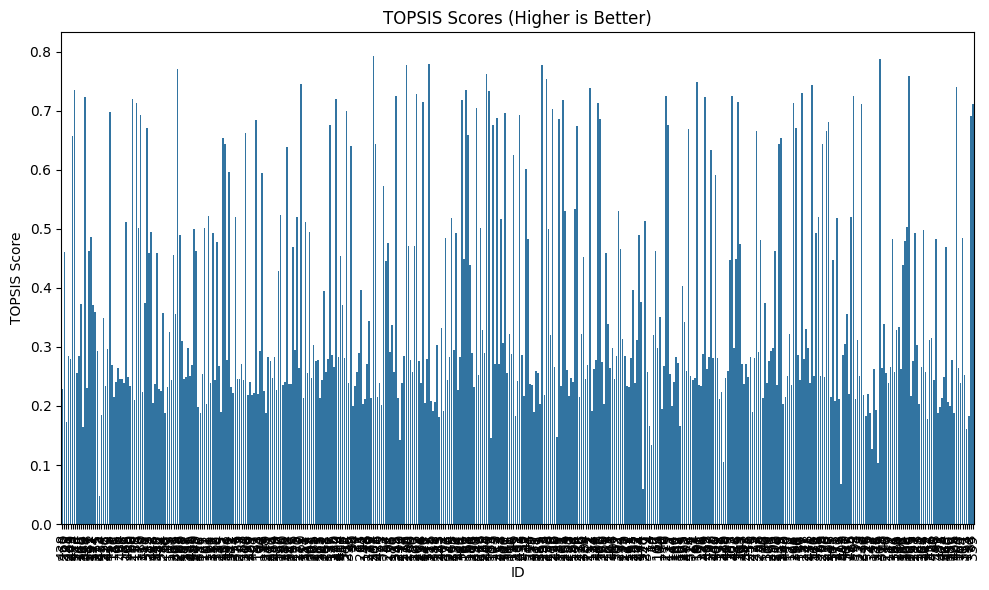

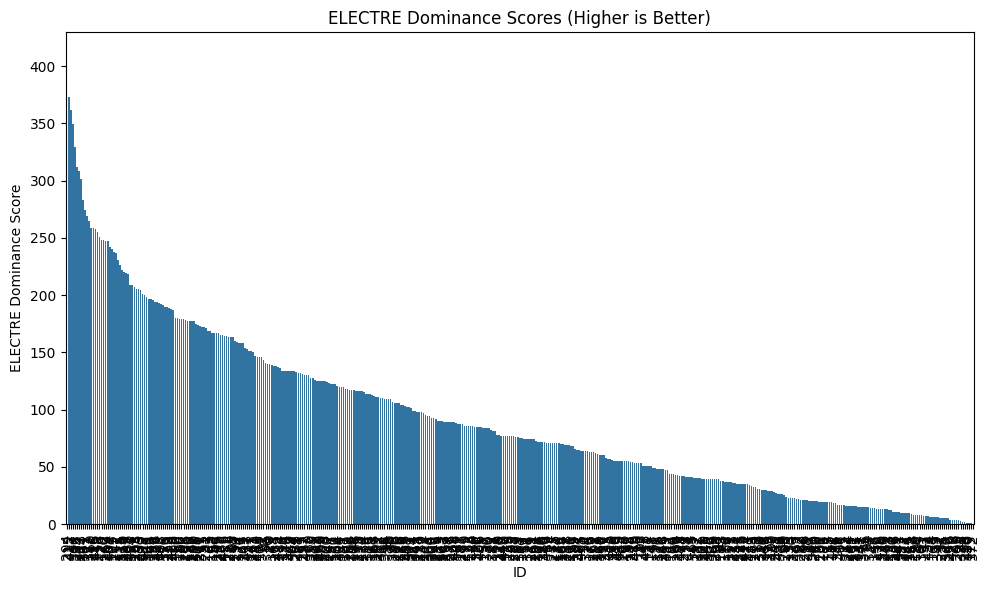

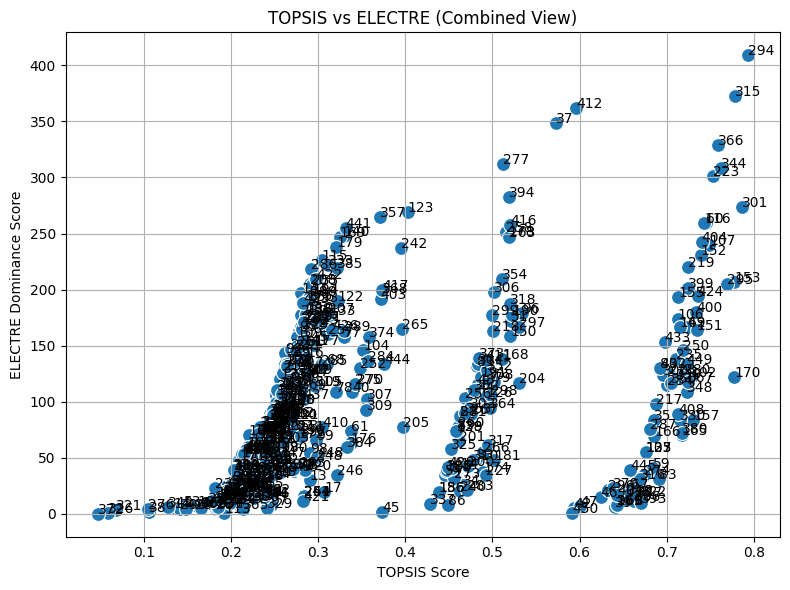

In [2]:
# multi_criteria_ranking_demo.ipynb
# =================================
# 🚀 AHP + TOPSIS + ELECTRE Interactive Demo 🚀

# -------------------------------------
# Giriş ve kütüphaneler
# -------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# Parametrik Threshold Seçimi
# -------------------------------------

# ELECTRE threshold parametreleri (buradan oynayabilirsin)
C_threshold = 0.65
D_threshold = 0.35

print(f"ELECTRE Thresholds → Concordance: {C_threshold}, Discordance: {D_threshold}")

# -------------------------------------
# Verileri yükle
# -------------------------------------

# AHP ağırlıkları
weights_path = "./outputs/ahp_weights_summary.xlsx"
weights_df = pd.read_excel(weights_path, sheet_name="Birlesik_Agirlik", index_col=0)
weights = weights_df["Birlesik_Agirlik"].values
criteria_names = weights_df.index.tolist()

# Aday verisi
candidates_path = "./outputs/processed_candidates_anonymized_scaled.xlsx"
candidates_df = pd.read_excel(candidates_path)
candidates_df.set_index("ID", inplace=True)
criteria_matrix = candidates_df[criteria_names].values

# Log
print(f"\nKriterler: {criteria_names}")
print(f"Aday sayısı: {criteria_matrix.shape[0]}")
print(f"Kriter sayısı: {criteria_matrix.shape[1]}")

# -------------------------------------
# TOPSIS Hesaplama
# -------------------------------------

norm = np.linalg.norm(criteria_matrix, axis=0)
normalized_matrix = criteria_matrix / norm
weighted_matrix = normalized_matrix * weights

ideal_solution = np.max(weighted_matrix, axis=0)
anti_ideal_solution = np.min(weighted_matrix, axis=0)

distance_to_ideal = np.linalg.norm(weighted_matrix - ideal_solution, axis=1)
distance_to_anti_ideal = np.linalg.norm(weighted_matrix - anti_ideal_solution, axis=1)

topsis_scores = distance_to_anti_ideal / (distance_to_ideal + distance_to_anti_ideal)
topsis_ranking = np.argsort(topsis_scores)[::-1] + 1

topsis_df = candidates_df.copy()
topsis_df["TOPSIS_Score"] = topsis_scores
topsis_df["TOPSIS_Rank"] = topsis_ranking

# -------------------------------------
# ELECTRE Hesaplama
# -------------------------------------

n_candidates = criteria_matrix.shape[0]
n_criteria = criteria_matrix.shape[1]

C_matrix = np.zeros((n_candidates, n_candidates))
D_matrix = np.zeros((n_candidates, n_candidates))

for i in range(n_candidates):
    for j in range(n_candidates):
        if i == j:
            continue
        concordance_indices = criteria_matrix[i, :] >= criteria_matrix[j, :]
        Cij = np.sum(weights[concordance_indices])
        C_matrix[i, j] = Cij
        
        differences = np.abs(criteria_matrix[i, :] - criteria_matrix[j, :])
        max_diff = np.max(differences)
        if max_diff == 0:
            D_matrix[i, j] = 0
        else:
            Dij = np.max((criteria_matrix[j, :] - criteria_matrix[i, :]) / max_diff)
            D_matrix[i, j] = Dij

outranking_matrix = np.zeros((n_candidates, n_candidates))

for i in range(n_candidates):
    for j in range(n_candidates):
        if i == j:
            continue
        if C_matrix[i, j] >= C_threshold and D_matrix[i, j] <= D_threshold:
            outranking_matrix[i, j] = 1
        else:
            outranking_matrix[i, j] = 0

dominance_scores = np.sum(outranking_matrix, axis=1)

electre_df = pd.DataFrame({
    "ID": candidates_df.index,
    "ELECTRE_Dominance_Score": dominance_scores
}).set_index("ID")

electre_df["ELECTRE_Rank"] = electre_df["ELECTRE_Dominance_Score"].rank(ascending=False, method='min').astype(int)

# -------------------------------------
# Combined Report
# -------------------------------------

combined_df = pd.DataFrame(index=candidates_df.index)
combined_df["TOPSIS_Score"] = topsis_df["TOPSIS_Score"]
combined_df["TOPSIS_Rank"] = topsis_df["TOPSIS_Rank"]
combined_df["ELECTRE_Dominance_Score"] = electre_df["ELECTRE_Dominance_Score"]
combined_df["ELECTRE_Rank"] = electre_df["ELECTRE_Rank"]

# -------------------------------------
# Görselleştirme
# -------------------------------------

# TOPSIS Rank barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_df.index, y=combined_df["TOPSIS_Score"], order=combined_df.sort_values("TOPSIS_Rank").index)
plt.title("TOPSIS Scores (Higher is Better)")
plt.ylabel("TOPSIS Score")
plt.xlabel("ID")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ELECTRE Dominance Score barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_df.index, y=combined_df["ELECTRE_Dominance_Score"], order=combined_df.sort_values("ELECTRE_Rank").index)
plt.title("ELECTRE Dominance Scores (Higher is Better)")
plt.ylabel("ELECTRE Dominance Score")
plt.xlabel("ID")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Combined scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x="TOPSIS_Score", y="ELECTRE_Dominance_Score", s=100)
for i, txt in enumerate(combined_df.index):
    plt.annotate(txt, (combined_df["TOPSIS_Score"].iloc[i], combined_df["ELECTRE_Dominance_Score"].iloc[i]))
plt.title("TOPSIS vs ELECTRE (Combined View)")
plt.xlabel("TOPSIS Score")
plt.ylabel("ELECTRE Dominance Score")
plt.grid(True)
plt.tight_layout()
plt.show()
